In [28]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import unidecode 
import pandas as pd 
import re 
import time 
import nltk 
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
from autocorrect import Speller
from bs4 import BeautifulSoup
from nltk.corpus import stopwords 
from nltk import word_tokenize
import string
import json

import warnings
warnings.filterwarnings('ignore')


import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

from pylab import rcParams
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

[nltk_data] Downloading package punkt to /Users/kian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/kian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/kian/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/kian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
df = pd.read_csv("sentiment140.csv", header=None, encoding="latin-1")

In [30]:
df.shape

(1600000, 6)

In [31]:
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [32]:
df[0]

0          0
1          0
2          0
3          0
4          0
          ..
1599995    4
1599996    4
1599997    4
1599998    4
1599999    4
Name: 0, Length: 1600000, dtype: int64

In [33]:
df.columns = ['class', 'tweet_id', 'datetime', 'query', 'id', 'tweet']

In [34]:
df

,class,tweet_id,datetime,query,id,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [35]:
len(df.id.unique())

659775

In [36]:
for t in df.tweet.head(50):
    print(t)

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds
my whole body feels itchy and like its on fire 
@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. 
@Kwesidei not the whole crew 
Need a hug 
@LOLTrish hey  long time no see! Yes.. Rains a bit ,only a bit  LOL , I'm fine thanks , how's you ?
@Tatiana_K nope they didn't have it 
@twittera que me muera ? 
spring break in plain city... it's snowing 
I just re-pierced my ears 
@caregiving I couldn't bear to watch it.  And I thought the UA loss was embarrassing . . . . .
@octolinz16 It it counts, idk why I did either. you never talk to me anymore 
@smarrison i would've been the first, but i didn't have a gun.    not rea

In [37]:
tweets_list = list(df.tweet)
tweet_len = list(map(len, tweets_list))
df["tweet_len"] = tweet_len

In [38]:
df.head()

,class,tweet_id,datetime,query,id,tweet,tweet_len
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",115
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,111
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,89
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,47
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",111


In [39]:
df = df[df['tweet'].apply(lambda x : x.isascii())]

In [40]:
df['tweet'].apply(lambda x : x.isascii()).all()

True

<AxesSubplot:xlabel='class', ylabel='count'>

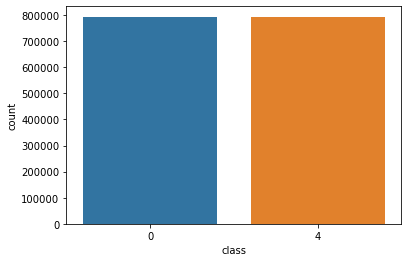

In [41]:
sns.countplot(df["class"])

In [42]:
##################### Creating moc df for faster dvelepment, remove for the main run #####################
df = df[:100]

In [43]:
def remove_newlines_tabs(text):
    formatted_text = text.replace('\\n', ' ').replace('\n', ' ').replace('\t',' ')
    formatted_text = formatted_text.replace('\\', ' ').replace('. com', '.com')
    return formatted_text

def remove_mentions_hashtagSigns(text):
    tokenized = text.split(" ")
    formatted_text = ""
    for w in tokenized:
        if not w:
            continue
        if w[0] == "@":
            continue
        if w[0] == "#":
            formatted_text += f"{w[1:]} "
        else:
            formatted_text += f"{w} "
            
    return formatted_text.strip()

def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text

def remove_punctuations(text):
    formatted = ""
    for char in text:
        if char in string.punctuation:
            continue
        else:
            formatted += char
    return formatted

def remove_links(text):
    remove_https = re.sub(r'http\S+', '', text)
    remove_com = re.sub(r"\ [A-Za-z]*\.com", " ", remove_https)
    return remove_com

def remove_whitespace(text):
    pattern = re.compile(r'\s+') 
    Without_whitespace = re.sub(pattern, ' ', text)
    text = Without_whitespace.replace('?', ' ? ').replace(')', ') ')
    return text

def accented_characters_removal(text):
    # Remove accented characters from text using unidecode.
    # Unidecode() - It takes unicode data & tries to represent it to ASCII characters. 
    text = unidecode.unidecode(text)
    return text

def lower_casing_text(text):
    return text.lower()

def reducing_incorrect_character_repeatation(text):
    Pattern_alpha = re.compile(r"([A-Za-z])\1{1,}", re.DOTALL)
    
    # Limiting all the  repeatation to two characters.
    Formatted_text = Pattern_alpha.sub(r"\1\1", text) 
    
    # Pattern matching for all the punctuations that can occur
    Pattern_Punct = re.compile(r'([.,/#!$%^&*?;:{}=_`~()+-])\1{1,}')
    
    # Limiting punctuations in previously formatted string to only one.
    Combined_Formatted = Pattern_Punct.sub(r'\1', Formatted_text)
    
    # The below statement is replacing repeatation of spaces that occur more than two times with that of one occurrence.
    Final_Formatted = re.sub(' {2,}',' ', Combined_Formatted)
    return Final_Formatted


def expand_contractions(text, contraction_mapping):
    list_Of_tokens = text.split(' ')
    for Word in list_Of_tokens: 
         if Word in contraction_mapping: 
            list_Of_tokens = [item.replace(Word, contraction_mapping[Word]) for item in list_Of_tokens]
                
    String_Of_tokens = ' '.join(str(e) for e in list_Of_tokens) 
    return String_Of_tokens

def removing_special_characters(text):
    formatted_text = re.sub(r"[^a-zA-Z0-9:$-,%.?!]+", ' ', text) 
    return formatted_text

def remove_numbers(text):
    formatted_text = re.sub(r"[^a-zA-Z:$-,%.?!]+", ' ', text)
    return formatted_text

stoplist = stopwords.words('english') 
stoplist = set(stoplist)
def removing_stopwords(text):
    text = repr(text)
    No_StopWords = [word for word in word_tokenize(text) if word.lower() not in stoplist]
    words_string = ' '.join(No_StopWords)    
    return words_string

def spelling_correction(text):
    spell = Speller(lang='en')
    Corrected_text = spell(text)
    return Corrected_text

In [44]:
def cleaning_and_preprocessing(tweet,
                              remove_newlines_=True,
                              remove_mentions_hashtagSigns_=True,
                              strip_html_tags_=True,
                              remove_punctuations_=True,
                              remove_links_=True,
                              remove_whitespace_=True,
                              accented_characters_removal_=True,
                              lower_casing_text_=True,
                              reducing_incorrect_character_repeatation_=True,
                              expand_contractions_=True,
                              remove_numbers_=True,
                              removing_stopwords_=False,
                              spelling_correction_=False):
    
    """
    input: a single text (e.g., a tweet or a sentence with type string).
    output: a single text (e.g., a tweet or a sentence with type string) which is clean:)
    """
    
    with open('contraction_map.json') as f:
        contraction_map = json.load(f)
    
    ## Clean
    text = tweet
    if remove_newlines_:
        text = remove_newlines_tabs(text)
    if remove_mentions_hashtagSigns_:
        text = remove_mentions_hashtagSigns(text)
    if strip_html_tags_:
        text = strip_html_tags(text)
    if remove_punctuations_:
        text = remove_punctuations(text)
    if remove_links_:
        text = remove_links(text)
    if remove_whitespace_:
        text = remove_whitespace(text)
    if  accented_characters_removal_:   
        text = accented_characters_removal(text)
    if lower_casing_text_:
        text = lower_casing_text(text)
    if reducing_incorrect_character_repeatation_:
        text = reducing_incorrect_character_repeatation(text)
    if expand_contractions_:
        text = expand_contractions(text, contraction_mapping=contraction_map)
    if remove_numbers_:
        text = remove_numbers(text)
    
    ## preprocessing
    if removing_stopwords_:
        text = removing_stopwords(text)
    if spelling_correction_:
        text = spelling_correction(text)
    return text


def lemmatization(text):
    """
        input: a single string text (e.g., tweet)
    """
    w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemma = [lemmatizer.lemmatize(w,'v') for w in w_tokenizer.tokenize(text)]
    return lemma    

In [45]:
def preprocess_all_tweets(df):
    """
        gets whole df as input.
        returns df with new column called cleaned tweets.
    """
    cleaned_tweets = []
    for tweet in df.tweet:
        cleaned_tweet = cleaning_and_preprocessing(tweet)
        cleaned_tweets.append(cleaned_tweet)
    
    df["cleaned_tweets"] = cleaned_tweets
    return df


def lemmatize_all_tweets(df):
    """
        gets whole df as input.
        returns df with new column called lemmatized tweets.
    """
    lemmatized_tweets = []
    for tweet in df.cleaned_tweets:
        lemmatized_tweet = cleaning_and_preprocessing(tweet)
        lemmatized_tweets.append(lemmatized_tweet)
    
    df["lemmatized_tweets"] = lemmatized_tweets
    return df

In [46]:
df = preprocess_all_tweets(df)
df = lemmatize_all_tweets(df)

In [47]:
df.head()

,class,tweet_id,datetime,query,id,tweet,tweet_len,cleaned_tweets,lemmatized_tweets
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",115,aww that is a bummer you shoulda got david ca...,aww that is a bummer you shoulda got david car...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,111,is upset that he cannot update his facebook by...,is upset that he cannot update his facebook by...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,89,i dived many times for the ball managed to sav...,i dived many times for the ball managed to sav...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,47,my whole body feels itchy and like it is on fire,my whole body feels itchy and like it is on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",111,no it is not behaving at all i am mad why am i...,no it is not behaving at all i am mad why am i...


In [48]:
df.lemmatized_tweets

0     aww that is a bummer you shoulda got david car...
1     is upset that he cannot update his facebook by...
2     i dived many times for the ball managed to sav...
3      my whole body feels itchy and like it is on fire
4     no it is not behaving at all i am mad why am i...
                            ...                        
95                       strider is a sick little puppy
96    so ryleegracewana go steves party or not sadly...
97    hey i actually won one of my bracket pools too...
98       you do not follow me either and i work for you
99    a bad nite for the favorite teams astros and s...
Name: lemmatized_tweets, Length: 100, dtype: object

In [49]:
pattern = r'''(?x)          # set flag to allow verbose regexps
        (?:[A-Z]\.)+        # abbreviations, e.g. U.S.A.
      | \w+(?:-\w+)*        # words with optional internal hyphens
      | \$?\d+(?:\.\d+)?%?\s?  # currency and percentages, e.g. $12.40, 82%
      | \.\.\.              # ellipsis
      | [][.,;"'?():_`-]    # these are separate tokens; includes ], [
    '''

pattern = re.compile(pattern)

final_tokenized_tweets = [nltk.regexp_tokenize(tweet, pattern)[1:-1] for tweet in df.lemmatized_tweets]

In [50]:
final_tokenized_tweets

[['that',
  'is',
  'a',
  'bummer',
  'you',
  'shoulda',
  'got',
  'david',
  'carr',
  'of',
  'third',
  'day',
  'to',
  'do',
  'it'],
 ['upset',
  'that',
  'he',
  'cannot',
  'update',
  'his',
  'facebook',
  'by',
  'texting',
  'it',
  'and',
  'might',
  'cry',
  'as',
  'a',
  'result',
  'school',
  'today',
  'also'],
 ['dived',
  'many',
  'times',
  'for',
  'the',
  'ball',
  'managed',
  'to',
  'save',
  'the',
  'rest',
  'go',
  'out',
  'of'],
 ['whole', 'body', 'feels', 'itchy', 'and', 'like', 'it', 'is', 'on'],
 ['it',
  'is',
  'not',
  'behaving',
  'at',
  'all',
  'i',
  'am',
  'mad',
  'why',
  'am',
  'i',
  'here',
  'because',
  'i',
  'cannot',
  'see',
  'you',
  'all',
  'over'],
 ['the', 'whole'],
 ['a'],
 ['long',
  'ti',
  'ame',
  'no',
  'see',
  'yes',
  'rains',
  'a',
  'bit',
  'only',
  'a',
  'bit',
  'lol',
  'i',
  'am',
  'fine',
  'thanks',
  'how',
  'is'],
 ['they', 'did', 'not', 'have'],
 ['me'],
 ['break', 'in', 'plain', 'city',

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
sample_text = "some tweet from out dataset"

encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()